In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import WaterPhantom
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ProjectUtils import ERE
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.ProjectUtils import E_THRESHOLD
from electronTransportCode.Material import Material, WaterMaterial
%matplotlib widget

In [2]:
# Set up initial conditions
eInit: float = 5.0/ERE  # 5 MeV initial energy
energyCutOff: float = E_THRESHOLD
SEED: int = 4  # Random number generator seed
xVariance: float = 0.1  # Variance on initial position in x and y direction
waterPhantomInit = WaterPhantom(minEnergy=energyCutOff, eSource=eInit, xVariance=xVariance, rngSeed=SEED)

In [3]:
# Set up simulation domain
simDomain = SimulationDomain(-2.5, 7.5, -2.5, 7.5, 200, 200, material=WaterMaterial)

# Set up dose estimator
doseEstimator = DoseEstimator(simDomain=simDomain)

# Set up particle
particle = SimplifiedEGSnrcElectron(generator=SEED)  # rng is later overridden by simulation object 

# Set up particle tracer
particleTracer = AnalogParticleTracer(particle=particle, simOptions=waterPhantomInit, simDomain=simDomain)

### Plot Stopping power for sanity check

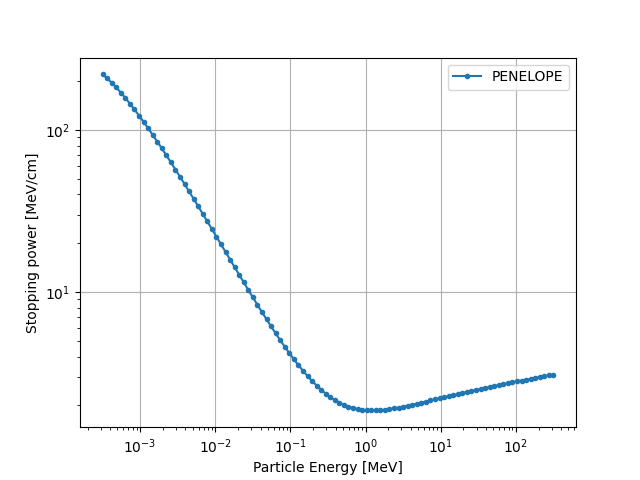

In [4]:
from electronTransportCode.Material import WaterMaterial
logrange = np.logspace(-3.5, 2.5, 100)  # MeV
stopping_power1 = np.array([particle.evalStoppingPower(E/ERE, None, WaterMaterial)*ERE for E in logrange])  # MeV/cm

plt.figure(1)
plt.loglog(logrange, stopping_power1, '.-', label='PENELOPE')
plt.xlabel('Particle Energy [MeV]')
plt.ylabel('Stopping power [MeV/cm]')
plt.legend()
plt.grid()

### Plot angular distribution 
The angular distribution is sharply peaked in the forward direction ($\mu = 0$)

In [13]:
from electronTransportCode.ProjectUtils import FSC, Re, ERE
import math
def evalSRDCS(mu: float, Ekin: float, material: Material) -> float:
    ''' Evaluate screened rutherford elastic differential cross-section
    '''
    betaSquared = Ekin*(Ekin+2)/math.pow(Ekin+1, 2)
    eta = material.etaCONST2/(Ekin*(Ekin+2))    
    return 2*math.pi*math.pow(Re*material.Z, 2)/((betaSquared*Ekin*(Ekin+2))*(math.pow(1-mu+2*eta, 2)))

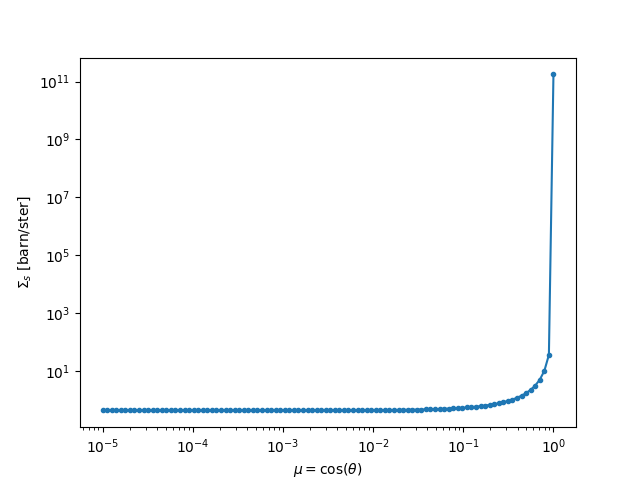

In [32]:
# Plot DCS
Ekin = 5.0/ERE  # 5.0 MeV
muArray = np.logspace(-5, 0, 100)
dcs = np.array([evalSRDCS(mu, Ekin, WaterMaterial) for mu in muArray])*1e24

fig, ax1 = plt.subplots()

ax1.loglog(muArray, dcs, '.-')
ax1.set_xlabel('$\mu = \cos(\\theta)$')
ax1.set_ylabel('$\Sigma_s$ [barn/ster]')
fig.savefig('figures/srdcs.pdf', format='pdf')

### Cross section

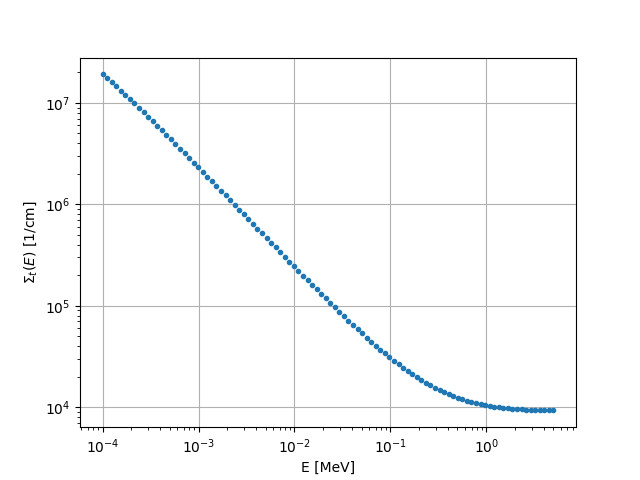

In [34]:
# Evaluate cross-section
particle = SimplifiedEGSnrcElectron(generator=4)

Erange = np.logspace(-4, np.log10(5.0), 100)  # MeV
cs = np.fromiter((particle.getScatteringRate(None, E/ERE, WaterMaterial) for E in Erange), dtype=float)  # type: ignore

fig, ax1 = plt.subplots()

ax1.loglog(Erange, cs, '.')
ax1.set_xlabel('E [MeV]')
ax1.set_ylabel('$\Sigma_t(E)$ [1/cm]')
ax1.grid()
fig.savefig('figures/srcs.pdf', format='pdf')


### Do simulation

In [9]:
# Run simulation
NB_PARTICLES = 10
particleTracer(nbParticles=NB_PARTICLES, estimators=doseEstimator)
print(f'Average amount of events: {particleTracer.averageNbCollisions}')

Average amount of events: 25967.3


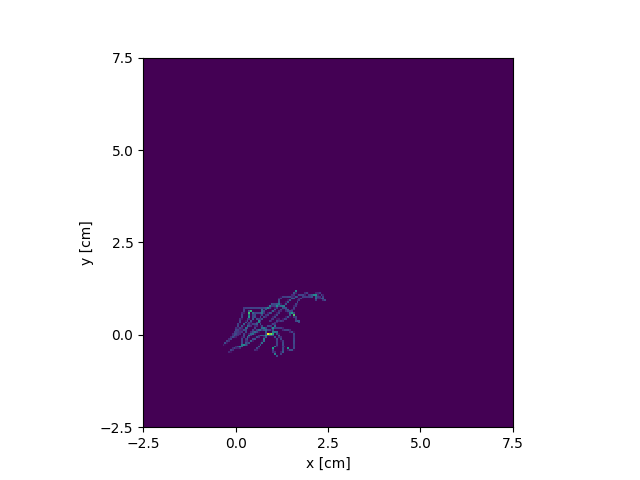

In [10]:
# Plot energy deposition
energyDeposition_ERE = np.reshape(doseEstimator.scoreMatrix, (simDomain.ybins, simDomain.xbins) )

fig, ax = plt.subplots()
ax.matshow(energyDeposition_ERE, extent=[-2.5, 7.5, -2.5, 7.5], origin='lower')
ax.set_xticks(np.linspace(-2.5, 7.5, 5))
ax.set_yticks(np.linspace(-2.5, 7.5, 5))
ax.xaxis.tick_bottom()
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
plt.show()

Text(0, 0.5, 'Energy deposition [1/ERE]')

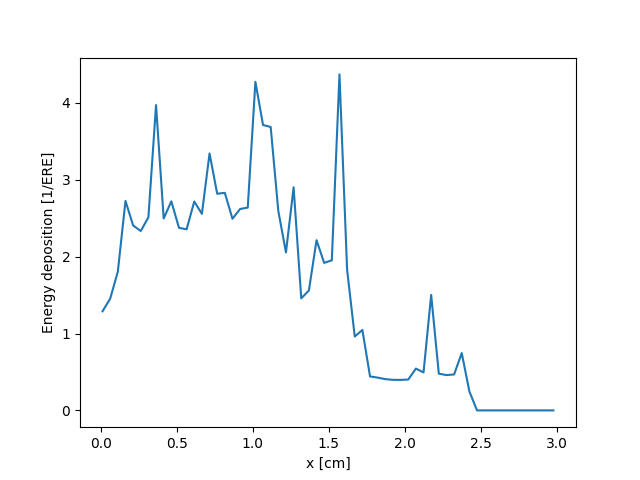

In [11]:
xEnergyDeposition_ERE = energyDeposition_ERE.sum(axis=0)
startIndex = 50
endIndex = 110
x = np.linspace(-2.5, 7.5, 200)
fig, ax = plt.subplots()
ax.plot(x[startIndex:endIndex], xEnergyDeposition_ERE[startIndex:endIndex])
ax.set_xlabel('x [cm]')
ax.set_ylabel('Energy deposition [1/ERE]')